# KL divergence

**Motivation:** Lukas had encouraged me to look at "successful" and "unsuccessful" examples for the SA that I have, and I noticed that although I had a "gut intuition" for what losses I was targetting, I realized that the BCE was positive (and larger than my hoped for value) for very overlapping images, 

1) The BCE was _a lot_ higher than I was anticipating (for well classified images) and
2) I was curious if this was messing up my training if I'm taking big steps when even the loss was as low as it could be.

**Note:** I should have been able to realize this before, because the global PFlow paper uses the KL divergence to learn the incidence matrix.

Nicole Hartman \
14 Sept 2023

In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mlp
from mpl_toolkits.axes_grid1 import make_axes_locatable

import json, yaml, os
os.sys.path.append('code')

from plotting import plot_kslots, plot_kslots_iters
from data import make_batch
from model import SlotAttentionPosEmbed

# Set numpy seed for test set sampling 
np.random.seed(24082023)

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cpu'

**Step 1:** Load in the model

In [3]:
cID_prev = 'learn-init-warm2'
with open(f'code/configs/{cID_prev}.yaml') as f:
    cd = yaml.safe_load(f)

hps = cd['hps']
hps['device'] = device

hps

{'hidden_dim': 16,
 'k_slots': 3,
 'query_dim': 128,
 'softmax_T': 'default',
 'learn_init': True,
 'device': 'cpu'}

In [4]:
torch_seed = 29082023
torch.manual_seed( torch_seed )

import random
random.seed(torch_seed)

In [5]:
m = SlotAttentionPosEmbed(**hps)

In [6]:
lastIter = 900_000
weightPath = f'code/models/{cID_prev}/m_{lastIter}.pt'
print(f'Starting from an earlier training',lastIter)

m.load_state_dict(torch.load(weightPath,map_location=device))

Starting from an earlier training 900000


<All keys matched successfully>

Create the "toy" test set... consistent with the `Cosine-similarity.ipynb`.

In [7]:
bs = 100
kwargs = cd['data']

X,y, mask = make_batch(N_events=bs, **kwargs)

/gpfs/slac/atlas/fs1/d/nhartman/Slot Attention/code/data.py:94: RuntimeWarning: invalid value encountered in true_divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


Evaluate the model.

In [8]:
from train import hungarian_matching
import torch.nn.functional as F

k_slots=3
max_n_rings=2
resolution=(32,32)

In [9]:
with torch.no_grad():

    torch.manual_seed(torch_seed)
    queries, att, wts = m(X)

    flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))

    att_ext  = torch.tile(att.unsqueeze(2), dims=(1,1,max_n_rings,1)) 
    mask_ext = torch.tile(flat_mask.unsqueeze(1),dims=(1,k_slots,1,1)) 

    pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)

    indices = hungarian_matching(pairwise_cost)

    # Apply the sorting to the predict
    bis=torch.arange(bs).to(device)
    indices=indices.to(device)

    slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)


    rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

    # Calculate the loss
    loss = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1)


In [10]:
loss.shape

torch.Size([100, 1024])

In [11]:
loss_evt = loss.mean(axis=-1)

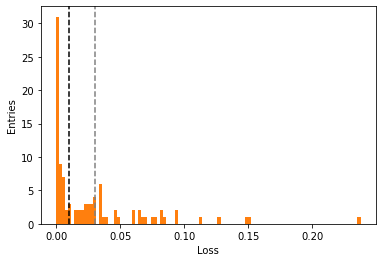

In [12]:
plt.hist(loss_evt.numpy(),100,color='C1')
plt.xlabel('Loss')
plt.ylabel('Entries')

ylim = plt.ylim()
plt.plot([.01]*2,ylim,'k--')
plt.plot([.03]*2,ylim,'grey',ls='--')
plt.ylim(ylim)

plt.show()

In [13]:
torch.mean(loss_evt)

tensor(0.0277)

In [14]:
mi = loss_evt < 0.01
torch.sum(mi)

tensor(49)

In [15]:
mj = loss_evt > 0.03
torch.sum(mj)

tensor(30)

In [16]:
good_imgs = mask[mi].sum(axis=1)
bad_imgs  = mask[mj].sum(axis=1)

In [17]:
good_imgs.shape

torch.Size([49, 32, 32])

**Step 2:** Make the plots of the "good" and "bad" examples

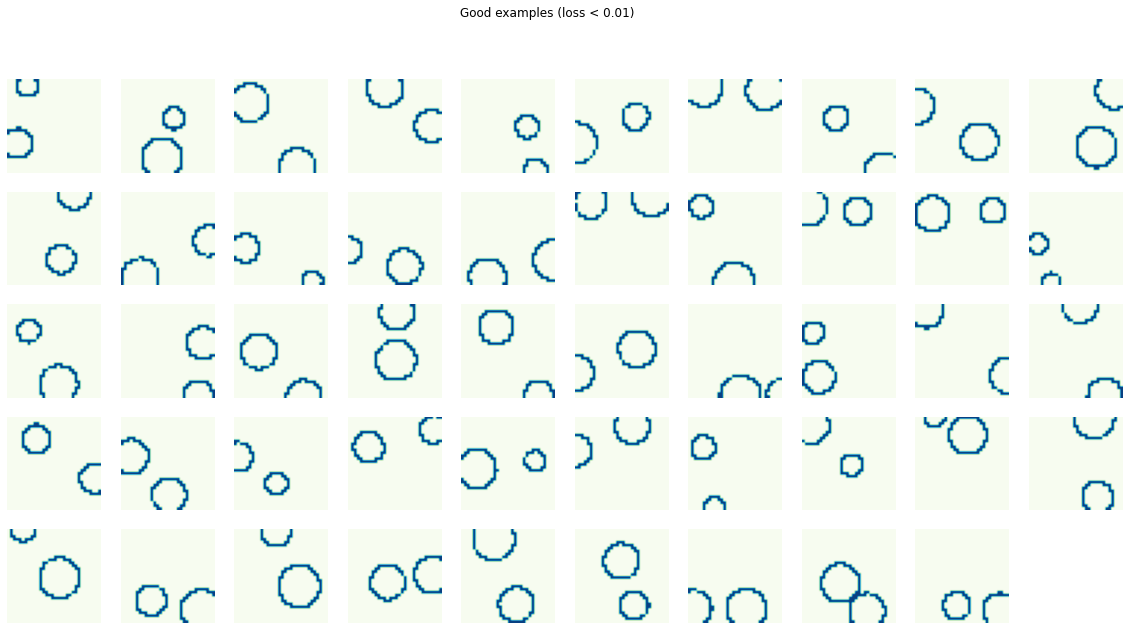

In [18]:
# Good exs
nrows = 5
ncols = 10

fig, axes = plt.subplots(nrows,ncols,figsize=(ncols*2,nrows*2))

for i, ax_i in enumerate(axes):

    for j, ax in enumerate(ax_i):

        k = i * ncols + j 
        ax.axis('off')
        
        if k >= len(good_imgs):
            break
        
        im = ax.imshow(good_imgs[k].numpy(),cmap='GnBu')

        
        # ax.set_title(0,0,f'evt={k}',transform=ax_ij.transAxes) 

fig.suptitle('Good examples (loss < 0.01)',va='top')
plt.show()

In [19]:
mask.shape

torch.Size([100, 2, 32, 32])

In [20]:
entropy = mask * np.log(np.where(mask==0, 1, mask))
entropy = - entropy.sum(dim=1).mean(dim=[1,2]) # sum over slots, mean over pixels

In [21]:
entropy.shape

torch.Size([100])

In [22]:
len(np.unique(entropy))

34

In [23]:
torch.sum(entropy[mj]==0)

tensor(13)

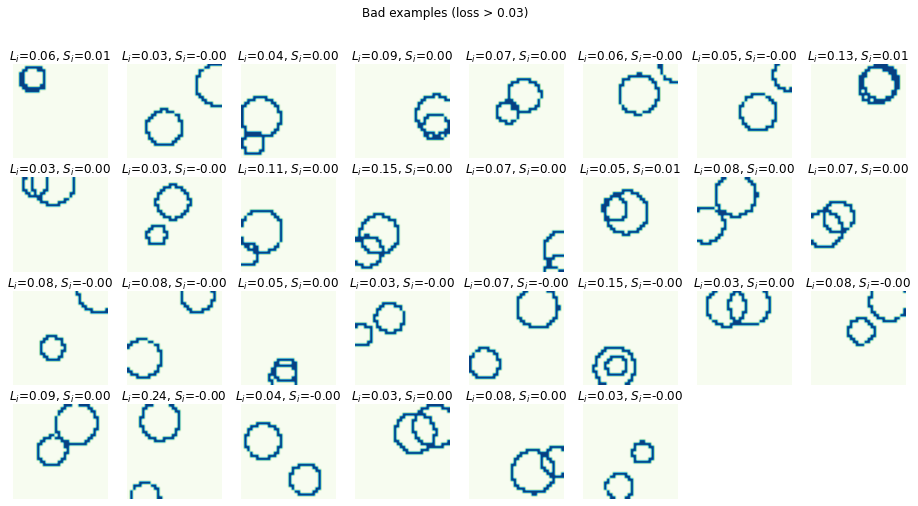

In [24]:
# Bad exs
nrows = 4
ncols = 8
fig, axes = plt.subplots(nrows,ncols,figsize=(ncols*2,nrows*2))

for i, ax_i in enumerate(axes):

    for j, ax in enumerate(ax_i):

        ax.axis('off')
        
        k = i * ncols + j 
        
        if k >= len(bad_imgs): continue
        
        im = ax.imshow(bad_imgs[k].numpy(),cmap='GnBu')
        ax.set_title(f'$L_i$={loss_evt[mj][k]:.2f}, $S_i$={entropy[mj][k]:.2f}',transform=ax.transAxes)
        
fig.suptitle('Bad examples (loss > 0.03)',va='top')
plt.show()

Interesting that actually 13 of these 30 "bad examples" are actually perfectly separated. 

I think I don't need to worry about these 13 for the "KL div" study... b/c this isn't the point of this check.

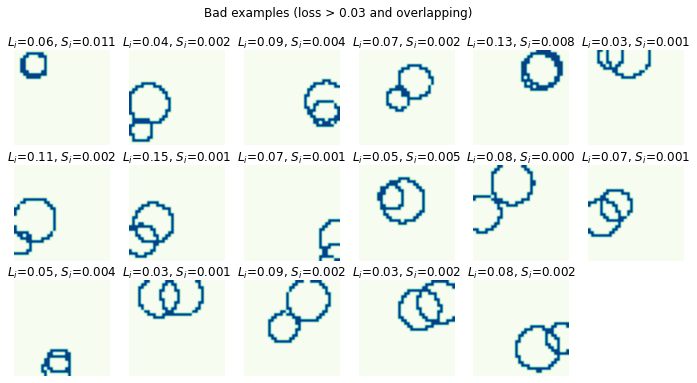

In [25]:
# Bad exs
nrows = 3
ncols = 6
fig, axes = plt.subplots(nrows,ncols,figsize=(ncols*2,nrows*2))

mk = mj & (entropy > 0)
OR_imgs = mask[mk].sum(axis=1)

for i, ax_i in enumerate(axes):

    for j, ax in enumerate(ax_i):

        ax.axis('off')
        
        k = i * ncols + j 
        
        if k >= len(OR_imgs): continue
        
        im = ax.imshow(OR_imgs[k].numpy(),cmap='GnBu')
        ax.set_title(f'$L_i$={loss_evt[mk][k]:.2f}, $S_i$={entropy[mk][k]:.3f}',transform=ax.transAxes)
        
fig.suptitle('Bad examples (loss > 0.03 and overlapping)',va='top')
plt.show()

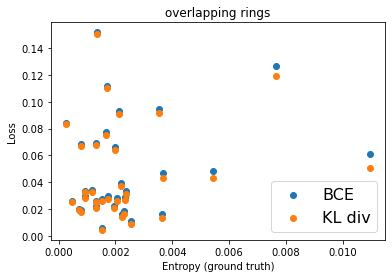

In [26]:
plt.scatter(entropy[entropy>0].numpy(),loss_evt[entropy>0],label='BCE')
plt.scatter(entropy[entropy>0].numpy(),loss_evt[entropy>0]-entropy[entropy>0].numpy(),label='KL div')
plt.title('overlapping rings')
plt.xlabel('Entropy (ground truth)')
plt.ylabel('Loss')
plt.legend(fontsize=16)
plt.show()

In [27]:
torch.mean(loss_evt[entropy>0])

tensor(0.0481)

In [28]:
torch.mean(loss_evt[entropy>0]-entropy[entropy>0])

tensor(0.0458)

In [29]:
0.0458/0.0481

0.9521829521829522

In [30]:
torch.mean(loss_evt-entropy) / torch.mean(loss_evt)

tensor(0.9723)

**2b** Look at the reco for these "bad examples"

In [33]:
def plot_chosen_slots(mask, att, cmap='Greens',suptitle=''):
    '''
    Almost identical to the plot_kslots fct, except no loss friend
    '''
    
    k_slots = att.shape[0]
    
    fig, axs = plt.subplots(1,k_slots+1,figsize=(2.75*k_slots,2.5))

    imgs   = [mask] + [ai for ai in att]
    titles = ['Target']+[f'Slot {i}' for i in range(k_slots)]
    
    for i, (ax,img,title) in enumerate(zip(axs,imgs, titles)):
        
        im = ax.imshow(img,cmap=cmap,vmin=0,vmax=1)
        ax.set_title(title)
        ax.axis('off')

    plt.suptitle(suptitle,va='top')
        
    plt.show()

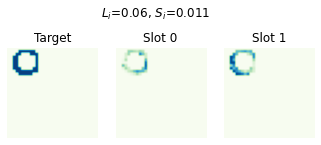

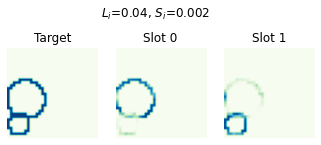

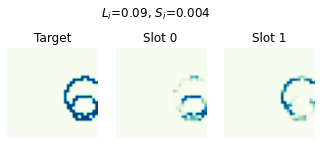

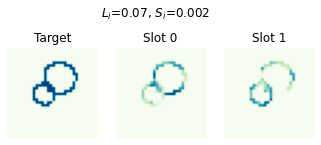

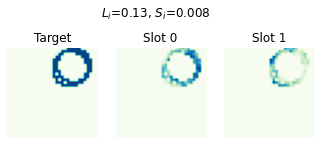

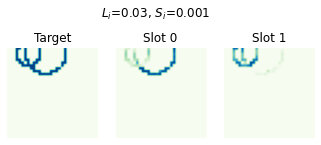

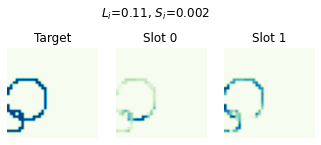

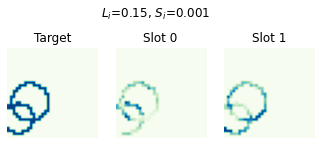

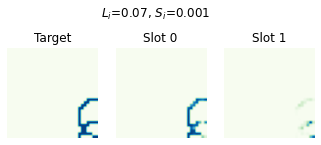

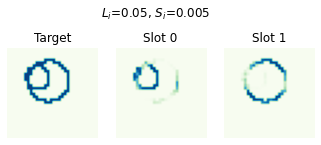

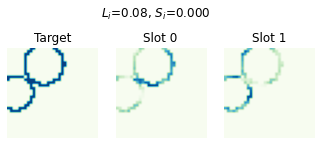

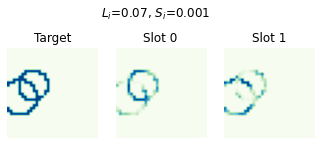

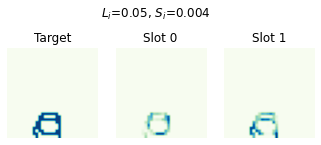

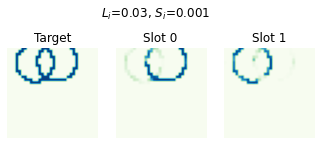

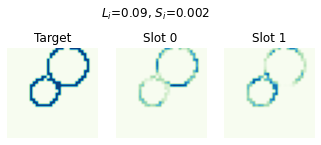

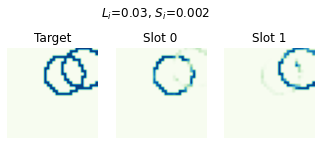

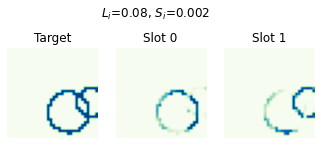

In [34]:
for mi, ai,li,si in zip(OR_imgs,slots_sorted[mk],loss_evt[mk],entropy[mk]):
    st = f'$L_i$={li:.2f}, $S_i$={si:.3f}'
    plot_chosen_slots(mi, ai.reshape(max_n_rings,*resolution), 'GnBu',st)

**Step 3:** Retrain with the KL divergence

Sanity check that I get the same answer w/ pytorch's `kl_div` function as when I'm calculating it by hand w/ the BCE and entropy functions.

In [40]:
# ?torch.nn.KLDivLoss

In [41]:
mask.shape

torch.Size([100, 2, 32, 32])

In [42]:
def img_entropy(mask):
    
    entropy = mask * torch.log(torch.where(mask==0, 1., mask.double()))
    entropy = - entropy.sum(dim=1).mean(dim=[1,2]) # sum over slots, mean over pixels

    return entropy.float()

In [43]:
img_entropy(mask).mean()

tensor(0.0008)

In [44]:
# loss_fct = torch.nn.KLDivLoss(reduction='none')
loss_fct = torch.nn.BCELoss(reduction='none')

In [45]:
with torch.no_grad():

    torch.manual_seed(torch_seed)
    queries, att, wts = m(X)

    '''
    For KL div, need to pass the inputs as log probs
    '''
    flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))

    att_ext  = torch.tile(att.unsqueeze(2), dims=(1,1,max_n_rings,1)) 
    mask_ext = torch.tile(flat_mask.unsqueeze(1),dims=(1,k_slots,1,1)) 

    # pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)
    pairwise_cost = loss_fct(att_ext,mask_ext).mean(axis=-1)

    indices = hungarian_matching(pairwise_cost)

    # Apply the sorting to the predict
    bis=torch.arange(bs).to(device)
    indices=indices.to(device)

    slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

    rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

    # Calculate the loss
    loss = loss_fct(slots_sorted,rings_sorted).sum(axis=1).mean(axis=1)
    loss -= img_entropy(mask)
    loss = loss.mean()
    
    # loss = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1)

In [46]:
img_entropy(mask).shape

torch.Size([100])

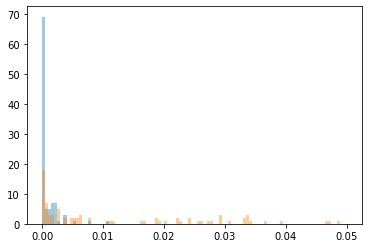

In [47]:
plt.hist(img_entropy(mask).numpy(),100,(0,.05),alpha=0.4)
plt.hist(loss_evt.numpy(),100,(0,.05),alpha=0.4)
plt.show()

In [48]:
# plt.scatter(loss_evt,loss)
# plt.plot([0,.25],[0,.25])
# plt.xlabel('`BCE')
# plt.ylabel('KL divergence')
# plt.show()

In [49]:
loss.mean()/ loss_evt.mean()

tensor(0.9723)

OK! _Let's do it!_

In [79]:
device='cuda:0'

In [80]:
X    = X.to(device)
mask = mask.to(device)

In [81]:
hps['device'] = device
model = SlotAttentionPosEmbed(**hps).to(device)
model.load_state_dict(torch.load(weightPath,map_location=device))

<All keys matched successfully>

In [68]:
model.device

'cuda:0'

In [69]:
T = 5_000
warmup_steps = 5000

xx = np.linspace(0,T,T)

lr = 3e-4
lr *= .5 * (1 + np.cos(xx * np.pi / T))
lr *= np.where(xx < warmup_steps, xx/warmup_steps,1)

In [70]:
numParams = 0
for p in model.parameters():
    # print(p.size())
    numParams += np.prod(p.size())

iter 0 , loss 0.0025665634 , lr 0.0


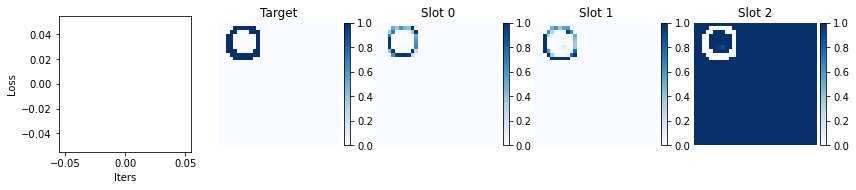

iter 500 , loss 0.0015273398 , lr 2.9271410698480475e-05


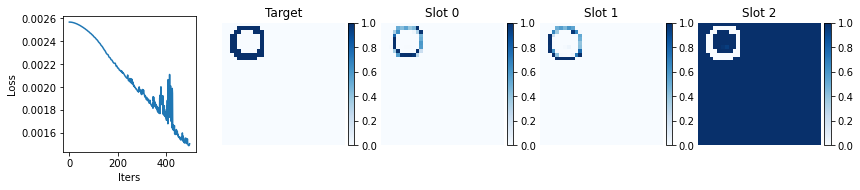

iter 1000 , loss 0.0010975902 , lr 5.4279149127906015e-05


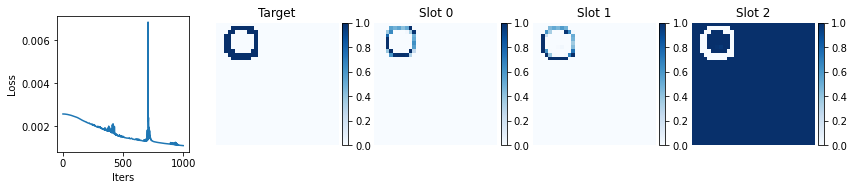

iter 1500 , loss 0.000947331 , lr 7.145776373813955e-05


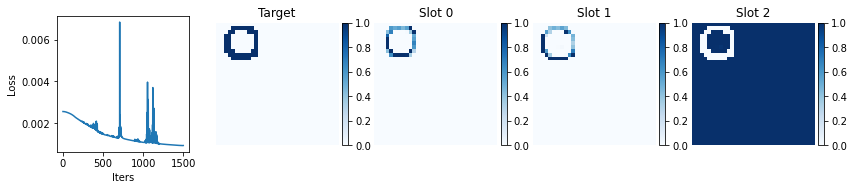

iter 2000 , loss 0.0008639273 , lr 7.854238309017214e-05


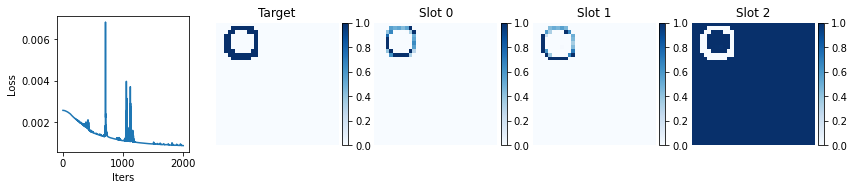

iter 2500 , loss 0.0008282052 , lr 7.499143162847993e-05


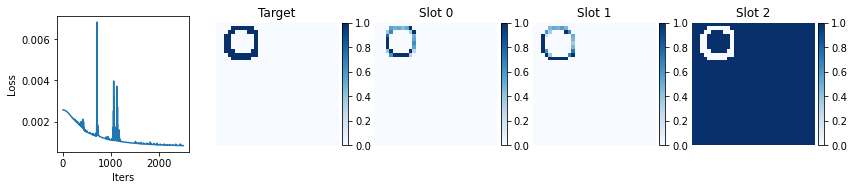

iter 3000 , loss 0.0008114497 , lr 6.21686311679755e-05


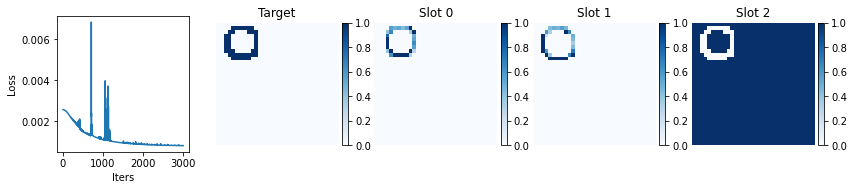

iter 3500 , loss 0.0008007913 , lr 4.325383622862997e-05


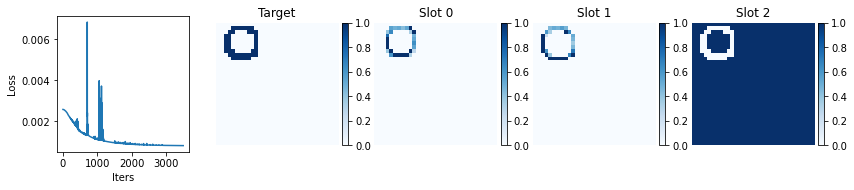

iter 4000 , loss 0.00079548196 , lr 2.288708890021406e-05


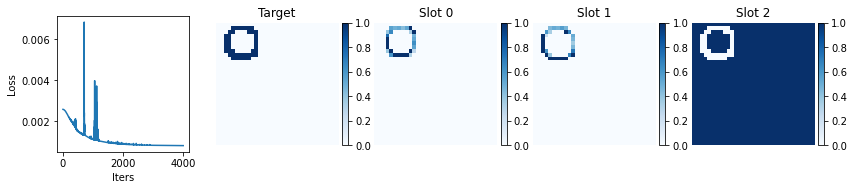

iter 4500 , loss 0.000793196 , lr 6.585112567348199e-06


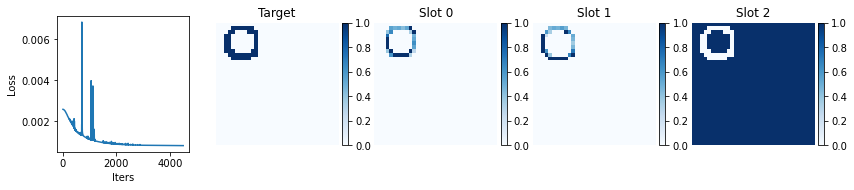

In [89]:
opt = torch.optim.Adam(model.parameters())
model.train()

losses = np.zeros(T)
grad_history = np.zeros((T,numParams))

for i,lr_i in enumerate(lr):

    opt.param_groups[0]['lr'] = lr_i
    
    torch.manual_seed(torch_seed)
    queries, att, wts = model(X)

    with torch.no_grad():
        flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))
        att_ext  = torch.tile(att.unsqueeze(2), dims=(1,1,max_n_rings,1)) 
        mask_ext = torch.tile(flat_mask.unsqueeze(1),dims=(1,k_slots,1,1)) 

        pairwise_cost = loss_fct(att_ext,mask_ext).mean(axis=-1)
        indices = hungarian_matching(pairwise_cost)

    # Apply the sorting to the predict
    bis=torch.arange(bs).to(device)
    indices=indices.to(device)

    slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

    rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

    # Calculate the loss
    loss = loss_fct(slots_sorted,rings_sorted).sum(axis=1).mean(axis=1)
    loss -= img_entropy(mask)
    loss = loss.mean()
    
    loss.backward()
    
    # Save the gradients
    grad_history[i] = np.concatenate([p.grad.cpu().flatten() for p in model.parameters()])
    
    # clip the gradients
    clipping_value = 1 # arbitrary value of your choosing
    torch.nn.utils.clip_grad_norm_(model.parameters(), clipping_value)
   
    opt.step()
    opt.zero_grad()

    losses[i] = float(loss)

    if i % 500 == 0:
        print('iter',i,', loss',loss.detach().cpu().numpy(),', lr',opt.param_groups[0]['lr'])

        iEvt = 0
        att_img = att[iEvt].reshape(k_slots,*resolution).detach().cpu().numpy()

        plot_kslots(losses[:i],mask[iEvt].sum(axis=0).cpu(), att_img,k_slots,color='C0',cmap='Blues')

    # break

In [83]:
# loss_dict = {}

loss_dict[clipping_value] = losses  


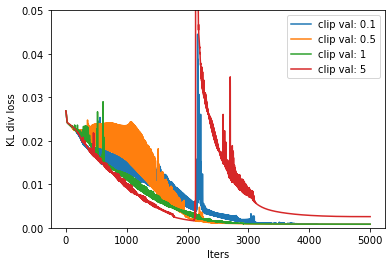

In [88]:
for cv in [.1,.5,1,5]:
    lv = loss_dict[cv]
    plt.plot(lv,label=f'clip val: {cv}')
    
plt.xlabel('Iters')
plt.ylabel('KL div loss')
plt.legend()
plt.ylim(0,0.05)
plt.show()

In [59]:
clipping_value

0.5

In [58]:
for i in range(500,800):
    dl = (losses[i] - losses[i-1]) 
    
    if dl > 0:
        print(i,dl)
        # print(i, losses[i])

501 0.0019251778721809387
504 0.0021739620715379715
505 0.0028732754290103912
509 0.001977585256099701
512 0.00217604823410511
513 0.002910260111093521
517 0.0020301658660173416
520 0.002176949754357338
521 0.002948341891169548
525 0.0020805969834327698
528 0.0021785106509923935
529 0.0029846858233213425
533 0.0021310187876224518
536 0.0021806377917528152
537 0.0030217263847589493
541 0.0021798647940158844
544 0.0021856091916561127
545 0.0030595920979976654
549 0.002227064222097397
552 0.002192515879869461
553 0.0030980147421360016
557 0.002272125333547592
560 0.0022003427147865295
561 0.00313551165163517
565 0.0023171305656433105
568 0.002208160236477852
569 0.0031732097268104553
573 0.0023614447563886642
576 0.002218373119831085
577 0.0032106079161167145
581 0.0024038199335336685
584 0.002228733152151108
585 0.0032497774809598923
589 0.0024451985955238342
592 0.0022425688803195953
593 0.0032890494912862778
597 0.0024847202003002167
600 0.0022582728415727615
601 0.0033276304602622986


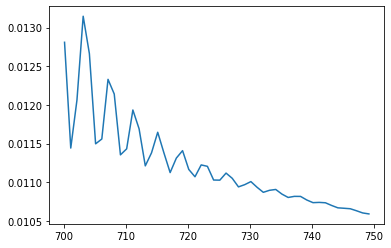

In [144]:
start = 700
stop = 750
plt.plot(xx[start:stop],losses[start:stop])

In [123]:
losses[709]

0.004030921030789614

In [124]:
losses[708]

0.0042999605648219585

In [125]:
losses[707]

0.004256373271346092

707 -1.4657208919525146 1.1095243692398071
708 -1.1390504837036133 1.5251582860946655
709 -1.302261233329773 0.9877598285675049


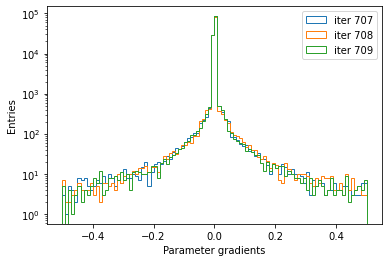

In [127]:
for i in [707,708,709]:

    print(i,grad_history[i].min(), grad_history[i].max())
    plt.hist(grad_history[i],100,(-.5,.5),histtype='step',log=True,label=f'iter {i}')

plt.xlabel('Parameter gradients')
plt.ylabel('Entries')
plt.legend()
plt.show()

Amazing!!

In [96]:
grad_history[losses>.8].shape

(1, 117840)

In [98]:
grad_history[losses>.8].min(),grad_history[losses>.8].max()

(-76308.21875, 60517.0)

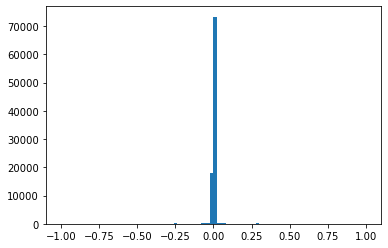

In [103]:
plt.hist(grad_history[losses>.8].flatten(),100,(-1,1))
plt.show()

In [104]:
losses.argmax()

2128

0 -0.05717383697628975 0.06507008522748947
500 -0.3321627378463745 0.4406887888908386
1000 -0.03445286676287651 0.027043906971812248
1500 -0.015690939500927925 0.013269155286252499
2000 -0.011415750719606876 0.012859812937676907


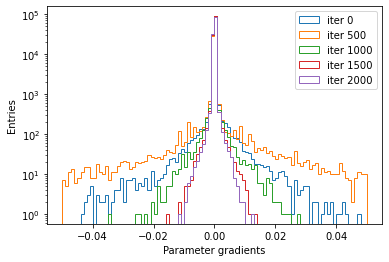

In [110]:
for i in [0,500, 1000,1500,2000]:

    print(i,grad_history[i].min(), grad_history[i].max())
    plt.hist(grad_history[i],100,(-.05,.05),histtype='step',log=True,label=f'iter {i}')

plt.xlabel('Parameter gradients')
plt.ylabel('Entries')
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():

    torch.manual_seed(torch_seed)
    queries, att, wts = model(X)

    flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))

    att_ext  = torch.tile(att.unsqueeze(2), dims=(1,1,max_n_rings,1)) 
    mask_ext = torch.tile(flat_mask.unsqueeze(1),dims=(1,k_slots,1,1)) 

    pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)

    indices = hungarian_matching(pairwise_cost)

    # Apply the sorting to the predict
    bis=torch.arange(bs).to(device)
    indices=indices.to(device)

    slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

    rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

    # Calculate the loss
    loss = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1)
    # loss -= entropy_np(mask.detach().cpu())
    

In [ ]:
loss.shape

In [ ]:
entropy_np(mask.detach().cpu()).shape

In [ ]:
kl_div = loss.mean(axis=1).cpu() - entropy_np(mask.detach().cpu())

In [ ]:
kl_div.max()

In [ ]:
plt.hist(kl_div.numpy(),100,(0,.035))
plt.show()

In [ ]:
for mi, ai,li,si in zip(OR_imgs,slots_sorted[mk],loss_evt[mk],entropy[mk]):
    st = f'$L_i$={li:.2f}, $S_i$={si:.3f}'
    plot_chosen_slots(mi, ai.reshape(max_n_rings,*resolution), 'GnBu',st)

I submitted some trainings 16.9.23, so let's evaluate them while they're training.

FileNotFoundError: [Errno 2] No such file or directory: 'code/models/kl-small-lr-cos/loss.json'

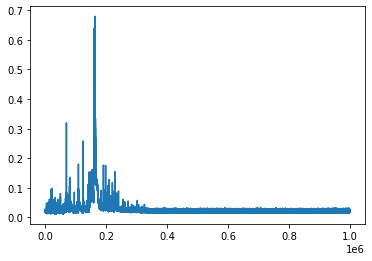

In [117]:
cIDs = [cID_prev,'kl-small-lr-cos','kl-small-lr-cos']

for cID in cIDs:

    with open(f'code/models/{cID}/loss.json') as f:
        ld = json.load(f)
        
    plt.plot(ld,label=cID)
    
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.xlim(0,len(ld))
plt.ylim(0,.1)
plt.legend()
plt.show()

Accidentally, I submitted some jobs w/o the gradient clipping.

But... not the end of the world, and it's a good diagnostic :)

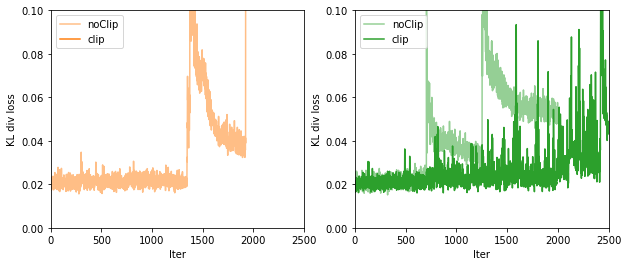

In [115]:
fig, axs = plt.subplots(1,2,figsize=(10,4))

for i,ax,l in zip([1,2],axs,['cos','exp']):

    for alpha,tag in zip([.5,1],['noClip','clip']):
    
        fname = f'code/models/kl-{l}Decay-{tag}/loss.json'
        with open(fname) as f:
            ld = json.load(f)
            
        ax.plot(ld,label=tag,color=f'C{i}',alpha=alpha)
        
    ax.set_xlabel('Iter')
    ax.set_ylabel('KL div loss')
    ax.legend()
    ax.set_xlim(0,2500)
    ax.set_ylim(0,.1)
    
plt.show()

OK, I think my initial learning rate is _too large_ when I'm starting from a warm start.

**Plan:** Reduce it from 2.75e-4 to 3e-5.

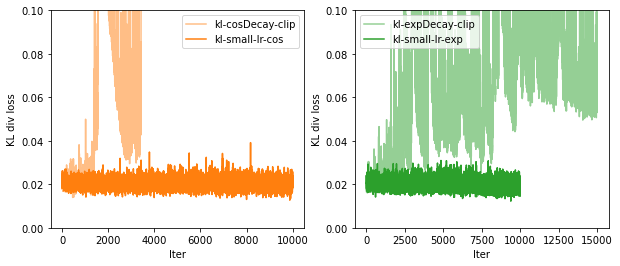

In [134]:
fig, axs = plt.subplots(1,2,figsize=(10,4))

for i,ax,l in zip([1,2],axs,['cos','exp']):

    for alpha,cID in zip([.5,1],[f'kl-{l}Decay-clip',f'kl-small-lr-{l}']):
    
        fname = f'code/models/{cID}/loss.json'
        with open(fname) as f:
            ld = json.load(f)
            
        ax.plot(ld,label=cID,color=f'C{i}',alpha=alpha)
        
    ax.set_xlabel('Iter')
    ax.set_ylabel('KL div loss')
    ax.legend()
    # ax.set_xlim(0,2500)
    ax.set_ylim(0,.1)
    
plt.show()

In [93]:
ld

[0.02225872315466404]

**Curiosity question:** Was the interactive training that I had to memorize 100 examples, did the centroids get (1) closer or (2) further apart during the training?

In [124]:
def get_loss(m,X,mask):

    with torch.no_grad():

        queries, att, wts = m(X)

    flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))

    att_ext  = torch.tile(att.unsqueeze(2), dims=(1,1,max_n_rings,1)) 
    mask_ext = torch.tile(flat_mask.unsqueeze(1),dims=(1,k_slots,1,1)) 

    pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)

    indices = hungarian_matching(pairwise_cost)

    # Apply the sorting to the predict
    bis=torch.arange(bs).to(device)
    indices=indices.to(device)

    slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

    rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

    # Calculate the loss
    # avg the pixel loss, but don't avg over the exs
    loss = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean(axis=-1)

    # And cosine sim b/w chosen centroids
    mus = torch.cat([queries[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    cs = torch.nn.CosineSimilarity()(mus[:,0],mus[:,1])

    return loss, cs

In [126]:
li, csi = get_loss(model,X,mask)

In [127]:
li

tensor([5.0323e-02, 3.6895e-05, 1.7374e-04, 2.9638e-05, 1.5638e-01, 1.0499e-04,
        9.3718e-07, 5.0773e-03, 9.4705e-03, 4.2615e-03, 1.5338e-01, 1.1043e-05,
        3.0433e-03, 6.0921e-05, 2.2631e-02, 1.0635e-04, 7.7504e-03, 5.4264e-03,
        6.7660e-04, 1.0883e-05, 1.9129e-04, 9.1103e-07, 8.8120e-05, 1.9041e-05,
        3.8788e-02, 5.4482e-06, 4.4234e-03, 1.5505e-05, 2.5462e-03, 5.8957e-06,
        6.1688e-03, 3.5506e-03, 3.8473e-05, 6.1383e-06, 5.4572e-03, 3.9888e-02,
        3.5011e-03, 6.8107e-03, 6.0531e-05, 7.3236e-06, 9.0888e-03, 5.7780e-05,
        6.7540e-03, 1.2152e-02, 1.0473e-01, 1.4274e-05, 1.0107e-01, 4.3033e-06,
        4.3264e-03, 1.1107e-05, 7.1899e-01, 1.0021e-02, 4.7549e-03, 1.6580e-05,
        1.1961e-03, 6.1991e-05, 1.0592e-04, 1.3418e-05, 2.4792e-01, 1.4023e-02,
        2.4636e-05, 9.7625e-03, 5.0123e-01, 2.4585e-02, 2.0641e-05, 2.5629e-06,
        8.9640e-06, 1.3769e-04, 7.4734e-05, 2.3234e-04, 2.9330e-04, 2.2293e-03,
        1.2262e-05, 1.6571e-03, 7.0857e-

In [129]:
csi.mean()

tensor(0.9357, device='cuda:0')

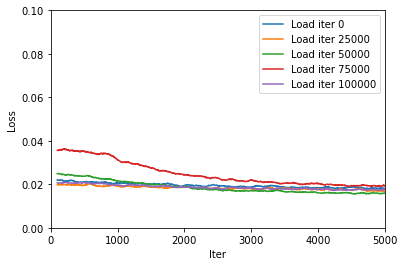

In [141]:
roll_avg=100

for i in [0,25_000,50_000,75_000,100_000]:
    cID = f'kl-small-lr-cos-{i}'

    with open(f'code/models/{cID}/loss.json') as f:
        ld = pd.Series(json.load(f))
        
    plt.plot(ld.rolling(roll_avg).mean()[roll_avg:],label=f'Load iter {i}',alpha=1)
    
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.xlim(0,len(ld))
plt.ylim(0,.1)
plt.legend()
plt.show()
    